# Webscraping State Election Results Pipeline

Webscraping presidential election results since 2000 to get engineer feature representing the average Democratic swing in each state for the last 6 election cycles.

This information will be joined on facility location/state as a proxy for the strength of emission regulations, under the assumption that more Democratic states have stricter restrictions. 

In [1]:
import requests, bs4
from bs4 import BeautifulSoup as bs
import pandas as pd

from fake_useragent import UserAgent

def remove_characters(state):
    for char in state:
        if char.isnumeric() == True:
            state = state.replace(char,'')
            state = state.replace('[]','')
    return state

def get_state_elections(year_list):
    ua = UserAgent()
    user_agent = {'User-agent': ua.random}
    all_data = {}
    
    dems_win = ['2008', '2012', '2020']
    repubs_win = ['2000','2004','2016']
    
    for year in year_list:
        url = "https://en.wikipedia.org/wiki/{}_United_States_presidential_election#Results".format(str(year))
        
        response  = requests.get(url)
        page = response.text
        
        election_soup = bs(page, 'html.parser')
        if year not in ['2016', '2020']:
            election_table = election_soup.find_all('table',{'class':'wikitable sortable'})
        elif year in ['2016']:
            election_table = election_soup.find_all('table',{'class':'wikitable sortable'})[2]
        elif year in ['2020']:
            election_table = election_soup.find_all('table',{'class':'wikitable sortable'})[1]
        
        df = pd.read_html(str(election_table))
        df = pd.DataFrame(df[0])
        
        # Keep only the relevant
        if year in ['2000','2004']:
            df_keep = df[[('Unnamed: 0_level_0','State'),('Margin','%')]]
        elif year == '2008':
            df_keep = df[[('Unnamed: 0_level_0','State/district'),('Margin','%')]]
        elif year == '2012':
            df_keep = df[[('Unnamed: 0_level_0','State/District'),('Margin','%')]]
        else:
            df_keep = df[[('State ordistrict','State ordistrict'),('Margin','%')]]
            df_keep = df_keep.dropna()
        
        # Flatten MultiIndex column names
        df_keep.columns = [''.join(col) for col in df_keep.columns.values]
        
        # Rename flatten columns
        if year in ['2000','2004']:
            df_final = df_keep.rename(columns = {'Unnamed: 0_level_0State':'State', 
                                             'Margin%':'Dem_margin%_{}'.format(str(year))})
        elif year in ['2008']:
            df_final = df_keep.rename(columns = {'Unnamed: 0_level_0State/district':'State', 
                                             'Margin%':'Dem_margin%_{}'.format(str(year))})
        elif year in ['2012']:
            df_final = df_keep.rename(columns = {'Unnamed: 0_level_0State/District':'State', 
                                             'Margin%':'Dem_margin%_{}'.format(str(year))})
        else:
            df_final = df_keep.rename(columns = {'State ordistrictState ordistrict':'State', 
                                             'Margin%':'Dem_margin%_{}'.format(str(year))})
        
        # Replace errant string characters in State name
        df_final['State'] = df_final['State'].str.replace('†','')
        df_final['State'] = df_final['State'].str.replace('*','')
        
        df_final['State'] = df_final['State'].apply(remove_characters)
        
        # Change state names to abbreviations - to join with GHG data tables
        if year not in ['2016','2020']:
            state_abbrev = pd.read_csv('csv_dict_files/state_abbrev_dict.csv')
            state_dict = pd.Series(state_abbrev.Abbrev.values, index = state_abbrev.State).to_dict()
            df_final.State = df_final.State.map(state_dict)
        elif year in ['2016']: 
            state_abbrev = pd.read_csv('csv_dict_files/state_abbrev_dict_2016_2020.csv')
            state_dict = pd.Series(state_abbrev.Abbrev.values, index = state_abbrev.State_2016).to_dict()
            df_final.State = df_final.State.map(state_dict)
        elif year in ['2020']:
            state_abbrev = pd.read_csv('csv_dict_files/state_abbrev_dict_2016_2020.csv')
            state_dict = pd.Series(state_abbrev.Abbrev.values, index = state_abbrev.State_2020).to_dict()
            df_final.State = df_final.State.map(state_dict)

        
        # Drop NaN values - issue comes from Nebraska and Maine reporting results for individual congressional
        # districts
        df_final.dropna(inplace = True)
        df_final = df_final.reset_index().drop(columns = 'index')
        
        # replace string values, and change data types
        df_final['Dem_margin%_{}'.format(str(year))] = df_final['Dem_margin%_{}'
                                                                .format(str(year))].str.replace('%','')
        df_final['Dem_margin%_{}'.format(str(year))] = df_final['Dem_margin%_{}'
                                                                .format(str(year))].str.replace('−','-').astype(float)
        
        # Wiki +/- is based on winner; change the sign if Repubs won to get Dem margin in each state
        if year in repubs_win:
            df_final['Dem_margin%_{}'.format(str(year))] = df_final['Dem_margin%_{}'.format(str(year))] * (-1)
        else:
            continue
            
        #df_final.sort_values('Dem_margin%_{}'.format(str(year)), ascending = True, inplace = True)
        df_final = df_final.reset_index().drop(columns = 'index')

        
    return df_final

In [2]:
df_2000 = get_state_elections(['2000'])
df_2004 = get_state_elections(['2004'])
df_2008 = get_state_elections(['2008'])
df_2012 = get_state_elections(['2012'])
df_2016 = get_state_elections(['2016'])
df_2020 = get_state_elections(['2020'])

<ipython-input-1-39858385f5fb>:69: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_final['State'] = df_final['State'].str.replace('*','')
<ipython-input-1-39858385f5fb>:69: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_final['State'] = df_final['State'].str.replace('*','')
<ipython-input-1-39858385f5fb>:69: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_final['State'] = df_final['State'].str.replace('*','')
<ipython-input-1-39858385f5fb>:69: FutureWarning: The default value of regex will change from True to False in a

In [3]:
df_merge = pd.merge(df_2000,df_2004, on = 'State')
df_merge = pd.merge(df_merge, df_2008, on = 'State')
df_merge = pd.merge(df_merge, df_2012, on = 'State')
df_merge = pd.merge(df_merge, df_2016, on = 'State')
df_election_merge = pd.merge(df_merge, df_2020, on = 'State')
df_election_merge

,State,Dem_margin%_2000,Dem_margin%_2004,Dem_margin%_2008,Dem_margin%_2012,Dem_margin%_2016,Dem_margin%_2020
0,AL,-14.92,-25.62,-21.58,-22.19,-27.73,-25.46
1,AK,-30.95,-25.55,-21.54,-13.99,-14.73,-10.06
2,AZ,-6.29,-10.47,-8.52,-9.06,-3.50,0.31
3,AR,-5.44,-9.76,-19.85,-23.69,-26.92,-27.62
4,CA,11.80,9.95,24.06,23.12,30.11,29.16
5,CO,-8.36,-4.67,8.95,5.37,4.91,13.50
6,CT,17.47,10.37,22.37,17.33,13.64,20.07
7,DE,13.06,7.59,25.00,18.63,11.37,18.97
8,DC,76.20,79.84,85.92,83.63,86.78,86.75
9,FL,-0.01,-5.01,2.82,0.88,-1.20,-3.36


In [4]:
df_election_merge['Dem_margin_avg%'] = (df_election_merge['Dem_margin%_2000'] + 
                                        df_election_merge['Dem_margin%_2000'] +
                                        df_election_merge['Dem_margin%_2000'] +
                                        df_election_merge['Dem_margin%_2000'] +
                                        df_election_merge['Dem_margin%_2000'] +
                                        df_election_merge['Dem_margin%_2000']) / 6
df_election_merge

,State,Dem_margin%_2000,Dem_margin%_2004,Dem_margin%_2008,Dem_margin%_2012,Dem_margin%_2016,Dem_margin%_2020,Dem_margin_avg%
0,AL,-14.92,-25.62,-21.58,-22.19,-27.73,-25.46,-14.92
1,AK,-30.95,-25.55,-21.54,-13.99,-14.73,-10.06,-30.95
2,AZ,-6.29,-10.47,-8.52,-9.06,-3.50,0.31,-6.29
3,AR,-5.44,-9.76,-19.85,-23.69,-26.92,-27.62,-5.44
4,CA,11.80,9.95,24.06,23.12,30.11,29.16,11.80
5,CO,-8.36,-4.67,8.95,5.37,4.91,13.50,-8.36
6,CT,17.47,10.37,22.37,17.33,13.64,20.07,17.47
7,DE,13.06,7.59,25.00,18.63,11.37,18.97,13.06
8,DC,76.20,79.84,85.92,83.63,86.78,86.75,76.20
9,FL,-0.01,-5.01,2.82,0.88,-1.20,-3.36,-0.01


In [5]:
df_election_merge.to_pickle('df_election_merge.pkl')

In [9]:
df_election_avg = df_election_merge[['State','Dem_margin_avg%']]
df_election_avg

,State,Dem_margin_avg%
0,AL,-14.92
1,AK,-30.95
2,AZ,-6.29
3,AR,-5.44
4,CA,11.80
5,CO,-8.36
6,CT,17.47
7,DE,13.06
8,DC,76.20
9,FL,-0.01


In [11]:
df_election_avg.to_pickle('df_election_avg.pkl')

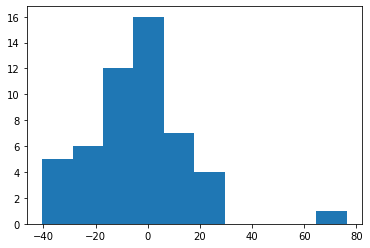

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(df_election_avg['Dem_margin_avg%']);

<font color = red>**_Outlier in the above histogram is DC which is not a state in the GHG data - will be dropped._**</font>